# MMLU Benchmark

Basic guide to running Massive Multitask Language Understanding (MMLU) benchmark using Llama models. In this experiment, we'll sample a subset of questions from the MMLU dataset, answer them, record metrics, and explore patterns in correct and incorrect questions.

# Imports

In [1]:
import logging
import os
from pathlib import Path
from random import sample
from time import perf_counter_ns as timer

from IPython.display import display
from matplotlib import pyplot as plt
from pandas import DataFrame
import seaborn as sns
from tqdm import tqdm

import llama_benchmarks as llb
from llama_benchmarks.models import llama
from llama_benchmarks.mmlu import Question, Questions, Answer, Answers, MMLULlamaGenerator

# Parameters

In [2]:
# Sample size
n_questions = 16

# Checkpoint
model = "Llama3.2-3B"

# Setup

In [3]:
# Switch to project root
if os.path.basename(os.getcwd()) == "experiments":
    os.chdir("..")

# Configure logger
logger = logging.getLogger(__name__)

# Path to datasets
datasets_path = Path(".build") / "datasets" 

In [4]:
def show_questions(questions: Questions):
    display(DataFrame(questions))

# MMLU Dataset

The Massive Multitask Language Understanding (MMLU) benchmark dataset from https://github.com/hendrycks/test contains 14,042 MCQs from 57 categories. Each question has 4 options A, B, C, and D and one correct answer. In addition, each category has 5 example questions designed for few-shot experiments.

In [5]:
mmlu_dataset_path = datasets_path / "mmlu"

# Load sample of questions from MMLU dataset
examples, questions = llb.mmlu.load_dataset(mmlu_dataset_path, n_questions=n_questions)
show_questions(sample(questions, k=3))

,category,question,A,B,C,D,answer
0,miscellaneous,A hard-edge painting is most likely to be char...,"an even, solid paint application",blurry color mixed on the painting's surface,scratchy brush marks clearly separated,translucent multiple layers of paint,A
1,computer security,You are given a message (m) and its OTP encryp...,"No, I cannot compute the key.","Yes, the key is k = m xor c.",I can only compute half the bits of the key.,"Yes, the key is k = m xor m.",B
2,high school psychology,Which of the following are found in Jung's col...,fictional finalisms,complexes,archetypes,feelings of inferiority,C


# Prompting

We combine each question with the relevant examples to generate few-shot prompts. The prompt template is based on the one used by Hendrycks et al. (2021) and implemented at https://github.com/hendrycks/test.

In [6]:
prompt = llb.mmlu.generate_prompt(examples, sample(questions, k=1)[0], n_shots=2)
print(prompt)

The following are multiple choice questions (with answers) about virology.

Question: Why are parvoviruses a highly impactful parasite?

A) Because they have no nucleic acid
B) They require a helper virus
C) Only replicate in dividing cells
D) Can integrate into host chromosomes

Answer: A

Question: The median survival time to AIDS and death was established by following:

A) Seroprevalent HIV-infected individuals
B) Seronegatives
C) Seroconverters
D) High-risk seronegatives

Answer: C

Question: Which of the following HPV viruses are known to cause cervical cancer?

A) Viruses of all 5 clades
B) Types 14, 16, 18, 31, 45
C) None are oncogenic per se
D) Types 1-180

Answer: 


# Generating Answers

In [7]:
# Create a Llama 3.2 3B MMLU generator
generator = MMLULlamaGenerator(llama.config(model))

In [8]:
start_time = timer()

answers = []
correct = 0
for answer in tqdm(generator(examples, questions), total=n_questions):
    answers.append(answer)
    if answer.correct:
        correct += 1

duration = timer() - start_time
print(f"Answering {n_questions} questions took {duration / 1000000000:0.3f}s")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.21it/s]

Answering 16 questions took 13.254s


In [9]:
# Calculate metrics
metrics = {
    "n": n_questions,
    "correct": correct,
    "accuracy": correct / n_questions,
    "rps": 1000000000 * n_questions / duration,
}

metrics

{'n': 16, 'correct': 11, 'accuracy': 0.6875, 'rps': 1.207155409889581}

# Analyzing Answers

In [11]:
# Correct questions
correct_answers = tuple(a for a in answers if a.correct)
correct_questions = tuple(questions[a.qid] for a in correct_answers)

# Incorrect questions
incorrect_answers = tuple(a for a in answers if not a.correct)
incorrect_questions = tuple(questions[a.qid] for a in incorrect_answers)

## Uncertainty: Correct Answers

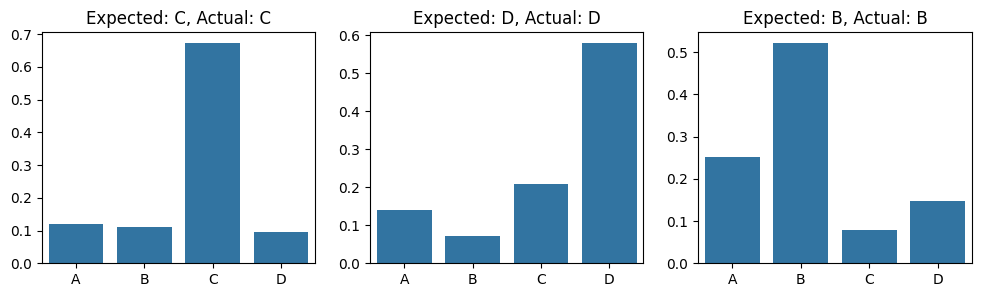

In [14]:
selected = sample(correct_answers, 3)

fig, axs = plt.subplots(ncols=len(selected), figsize=(12,3))
for i, answer in enumerate(selected):
    sns.barplot(data=answer.scores, ax=axs[i])
    axs[i].set_title(f"Expected: {answer.expected}, Actual: {answer.actual}")

## Uncertainty: Incorrect Answers

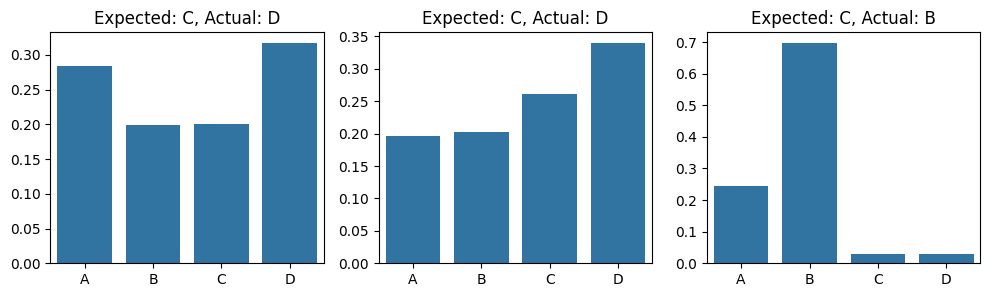

In [15]:
selected = sample(incorrect_answers, 3)

fig, axs = plt.subplots(ncols=len(selected), figsize=(12,3))
for i, answer in enumerate(selected):
    sns.barplot(data=answer.scores, ax=axs[i])
    axs[i].set_title(f"Expected: {answer.expected}, Actual: {answer.actual}")